In [1]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
import re
import gc
# mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fullmodel = T5ForConditionalGeneration.from_pretrained("../models/prottrans_t5_xl_u50/").to(device)

#fullmodel.full() if str(device)=='cpu' else fullmodel.half()

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('../models/prottrans_t5_xl_u50', do_lower_case=False, legacy=False)


In [3]:
if device == "cuda:0":
    torch.cuda.empty_cache()
else:
    print("No CUDA")

No CUDA


In [4]:
def sequence_masker(seq, i, j, same_extra_token=False):
    masked_sequence_list = seq.split()
    token_num = 0
    if j<=i:
        print(f"index j={j} must be greater than i={i}")
        raise
    for x in range(i, j):
        if j > len(seq):
            break
        masked_sequence_list[x] = f"<extra_id_{token_num}>"
        if not same_extra_token:
            token_num += 1
    return " ".join(masked_sequence_list)

test = "P R O T E I N A"


In [5]:
for record in SeqIO.parse("../disprot_OK_fullset.fasta", 'fasta'):
    print(record)
    break

ID: P03347
Name: P03347
Description: P03347
Number of features: 0
Seq('MGARASVLSGGELDRWEKIRLRPGGKKKYKLKHIVWASRELERFAVNPGLLETS...SSQ')


In [6]:
import random

testsequence = "CQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEED"
input_test = [" ".join(list(re.sub(r"[UZOB]", "X", testsequence)))]
print(f"Input protein: {input_test}")

masked_test = [sequence_masker(input_test[0], 10, 11)]
print(f"Masked protein: {masked_test}")

ids1 = tokenizer.batch_encode_plus(input_test, add_special_tokens=True, padding="longest")
print(ids1)
ids2 = tokenizer.batch_encode_plus(masked_test, add_special_tokens=True, padding="longest")
print(ids2)

print(tokenizer(input_test[0]))
# print(tokenizer(masked_test[0]))

Input protein: ['C Q K C D P S C P N G S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D']
Masked protein: ['C Q K C D P S C P N <extra_id_0> S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D']
{'input_ids': [[22, 16, 14, 22, 10, 13, 7, 22, 13, 17, 5, 7, 22, 21, 5, 3, 5, 9, 9, 17, 22, 16, 14, 4, 11, 14, 12, 12, 22, 3, 16, 16, 22, 7, 5, 8, 22, 8, 5, 14, 7, 13, 7, 10, 22, 22, 20, 17, 16, 22, 3, 3, 5, 22, 11, 5, 13, 8, 9, 7, 10, 22, 4, 6, 22, 8, 14, 15, 8, 10, 9, 3, 11, 22, 14, 10, 11, 22, 13, 13, 4, 19, 4, 18, 17, 13, 11, 11, 18, 16, 19, 10, 6, 17, 13, 9, 5, 14, 18, 7, 15, 5, 3, 11, 22, 6, 14, 14, 2

In [7]:
true_ids  = torch.tensor(ids1['input_ids']).to(device)
input_ids = torch.tensor(ids2['input_ids']).to(device)
attention_mask = torch.tensor(ids1['attention_mask']).to(device)

#embfull = fullmodel(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=input_ids)

In [8]:
print(attention_mask.shape)
print(attention_mask)

torch.Size([1, 136])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [9]:
with torch.no_grad():
    emb = fullmodel(input_ids=input_ids, labels=true_ids)
    loss = emb.loss
    print(loss.item())

0.02413642778992653


In [10]:
with torch.no_grad():
    emb = fullmodel(input_ids=input_ids, labels=true_ids, attention_mask=attention_mask, decoder_attention_mask=attention_mask)
    loss  = emb.loss.cpu()
    print(loss.item())

0.02413642778992653


In [11]:
output_toks = torch.argmax(emb.logits, dim=2)
print(output_toks)
tokenizer.decode(output_toks[0], skip_special_tokens=True)

tensor([[22, 16, 14, 22, 10, 13,  7, 22, 13, 17,  5,  5, 22, 21,  5,  3,  5,  9,
          9, 17, 22, 16, 14,  4, 11, 14, 12, 12, 22,  3, 16, 16, 22,  7,  5,  8,
         22,  8,  5, 14,  7, 13,  7, 10, 22, 22, 20, 17, 16, 22,  3,  3,  5, 22,
         11,  5, 13,  8,  9,  7, 10, 22,  4,  6, 22,  8, 14, 15,  8, 10,  9,  3,
         11, 22, 14, 10, 11, 22, 13, 13,  4, 19,  4, 18, 17, 13, 11, 11, 18, 16,
         19, 10,  6, 17, 13,  9,  5, 14, 18,  7, 15,  5,  3, 11, 22,  6, 14, 14,
         22, 13,  8, 17, 18,  6,  6, 11, 10, 20,  5,  7, 22,  6,  8,  3, 22,  5,
          3, 10,  7, 18,  9, 19,  9,  9, 10,  1]])


'C Q K C D P S C P N G G C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D'

Logits shape: torch.Size([1, 136, 128])


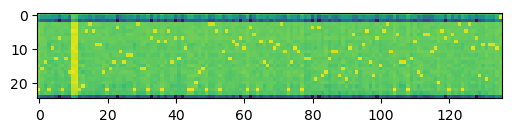

In [12]:
## Last layer of logits before SoftMax

import matplotlib.pyplot as plt

print(f"Logits shape: {emb.logits.shape}")

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# move tensor to cpu
logits_cpu = emb.logits[0,:,0:25].T.cpu() # only show first 25 tokens
ax.imshow(np.array(logits_cpu))
plt.show()

In [13]:
## Check of attention heads
attention_mask = torch.BoolTensor(np.ones((1,len(testsequence)+1,len(testsequence)+1))).to(device)
attention_mask = torch.tensor(ids1['attention_mask']).to(device)
print(attention_mask.shape)

with torch.no_grad():
    emb = fullmodel(input_ids=input_ids, labels=true_ids, output_attentions=True, attention_mask=attention_mask, decoder_attention_mask=attention_mask)
    loss  = emb.loss.cpu()
    print(loss)
print(emb.encoder_attentions[0].shape)
print(emb.decoder_attentions[0].shape)

## Does the attention mask work? no
attention_mask[0,0:10] = 0.0
attention_mask = torch.tensor(ids1['attention_mask']).to(device)

with torch.no_grad():
    emb = fullmodel(input_ids=input_ids, labels=true_ids, output_attentions=True, attention_mask=attention_mask, decoder_attention_mask=attention_mask)
    loss  = emb.loss.cpu()
    print(loss)



torch.Size([1, 136])
tensor(0.0241)
torch.Size([1, 32, 136, 136])
torch.Size([1, 32, 136, 136])
tensor(0.0241)


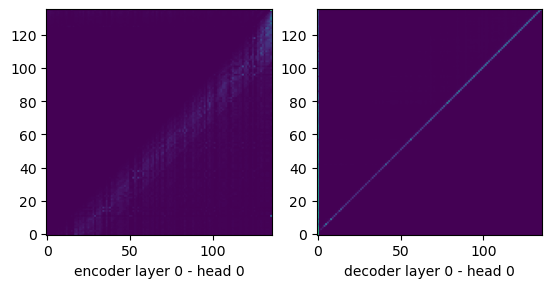

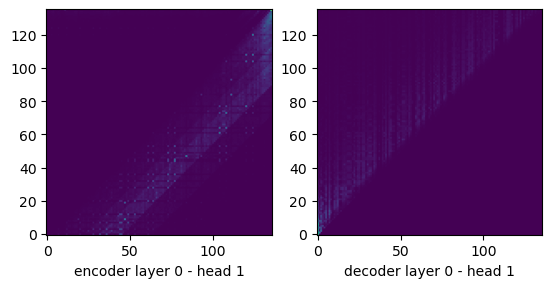

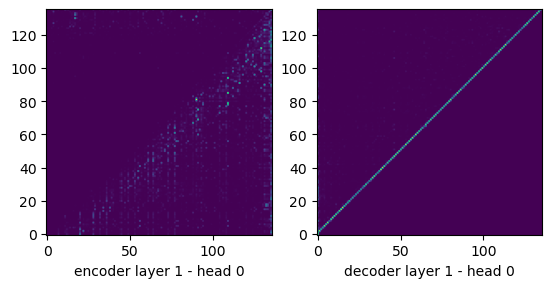

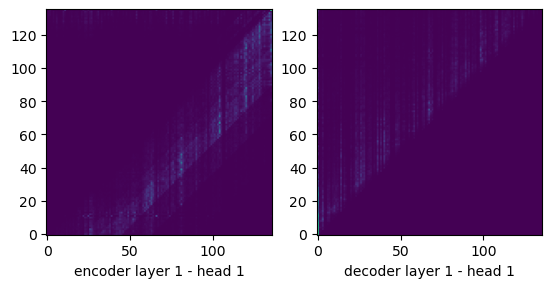

In [14]:
## Plot a few attention matrices
for j in range(2):
    for i in range(2):
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(emb.encoder_attentions[j][0,i,:].numpy(),origin='lower')
        ax[0].set_xlabel(f"encoder layer {j} - head {i}")
        ax[1].imshow(emb.decoder_attentions[j][0,i,:].numpy(),origin='lower')
        ax[1].set_xlabel(f"decoder layer {j} - head {i}")
        plt.show()

In [15]:
fullmodel.config.return_dict_in_generate=True

In [16]:
## Auto-regressively generate the output with beam=2.
## Requires L inference passes through the decoder
## https://huggingface.co/docs/transformers/v4.15.0/en/internal/generation_utils#transformers.generation_utils.GreedySearchEncoderDecoderOutput
print(masked_test)
print(input_ids)
with torch.no_grad():
    emb = fullmodel(input_ids=input_ids, labels=true_ids)
    outputs = fullmodel.generate(input_ids=input_ids, 
                                 max_length=200,
                                 labels=true_ids,
                                 num_beams=2,
                                 return_dict_in_generate=True,
                                 output_scores=True)
outputs
### tokenizer.get_vocab()

['C Q K C D P S C P N <extra_id_0> S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D']
tensor([[ 22,  16,  14,  22,  10,  13,   7,  22,  13,  17, 127,   2,  22,  21,
           5,   3,   5,   9,   9,  17,  22,  16,  14,   4,  11,  14,  12,  12,
          22,   3,  16,  16,  22,   7,   5,   8,  22,   8,   5,  14,   7,  13,
           7,  10,  22,  22,  20,  17,  16,  22,   3,   3,   5,  22,  11,   5,
          13,   8,   9,   7,  10,  22,   4,   6,  22,   8,  14,  15,   8,  10,
           9,   3,  11,  22,  14,  10,  11,  22,  13,  13,   4,  19,   4,  18,
          17,  13,  11,  11,  18,  16,  19,  10,   6,  17,  13,   9,   5,  14,
          18,   7,  15,   5,   3,  11,  22,   6,  14,  14,  22,  13,   8,  17,
          18,   6,   6,  11,  10,  20,   5,   7,  22,   6,   8,   3,  22,   5,
    

/usr/users/fsimonetti/miniconda3/envs/py39/lib/python3.9/site-packages/transformers/generation/utils.py:1411: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


BeamSearchEncoderDecoderOutput(sequences=tensor([[ 0, 22, 16, 14, 22, 10, 13,  7, 22, 13, 17,  5,  5, 22, 21,  5,  3,  5,
          9,  9, 17, 22, 16, 14,  4, 11, 14, 12, 12, 22,  3, 16, 16, 22,  7,  5,
          8, 22,  8,  5, 14,  7, 13,  7, 10, 22, 22, 20, 17, 16, 22,  3,  3,  5,
         22, 11,  5, 13,  8,  9,  7, 10, 22,  4,  6, 22,  8, 14, 15,  8, 10,  9,
          3, 11, 22, 14, 10, 11, 22, 13, 13,  4, 19,  4, 18, 17, 13, 11, 11, 18,
         16, 19, 10,  6, 17, 13,  9,  5, 14, 18,  7, 15,  5,  3, 11, 22,  6, 14,
         14, 22, 13,  8, 17, 18,  6,  6, 11, 10, 20,  5,  7, 22,  6,  8,  3, 22,
          5,  3, 10,  7, 18,  9, 19,  9,  9, 10,  1]]), sequences_scores=tensor([-0.0174]), scores=(tensor([[-27.1794, -39.8910, -57.9993, -24.9224, -23.5526, -21.1154, -22.8314,
         -21.8494, -23.5171, -28.3061, -26.2953, -23.4721, -22.4754, -21.5060,
         -24.8192, -21.3765, -27.9149, -22.3729, -22.5732, -23.1248, -22.6760,
         -24.1870,   0.0000, -21.7445, -59.0752, -58.64

In [17]:
len(outputs.scores)

137

torch.Size([136, 128])
C Q K C D P S C P N G G C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D</s>
C Q K C D P S C P N G G C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D</s>
C Q K C D P S C P N G G C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D</s>
['C Q K C D P S C P N <extra_id_0> S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E 

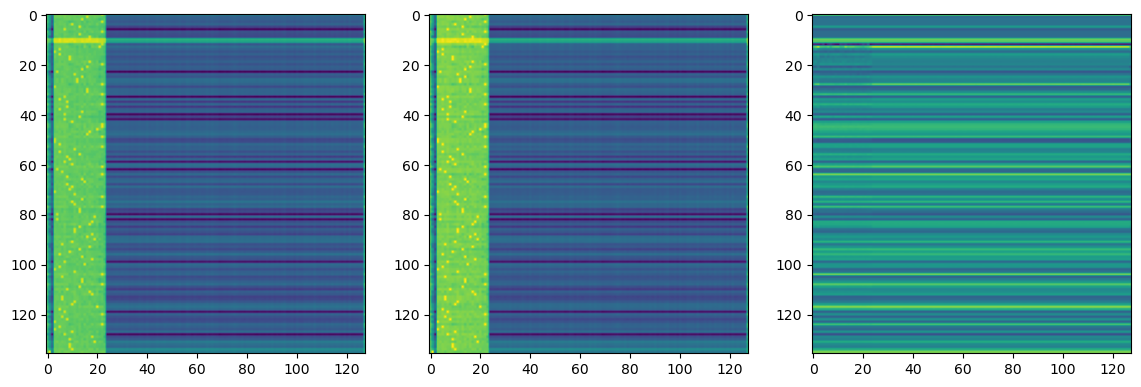

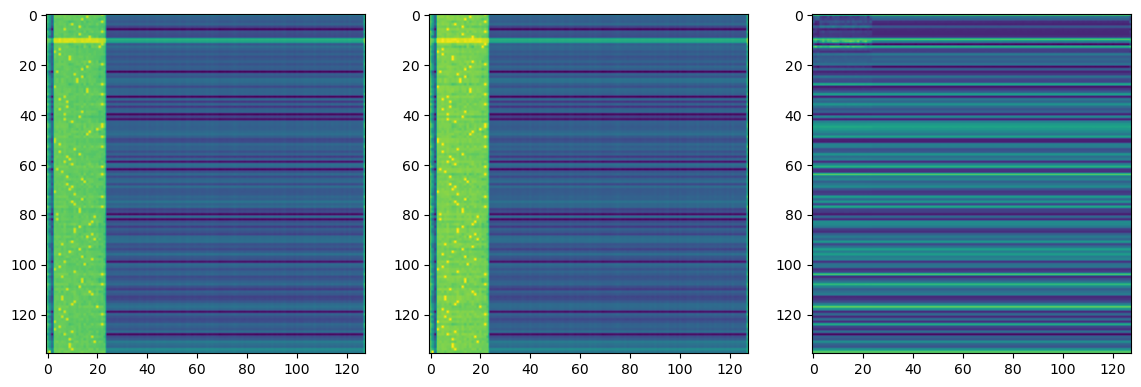

In [19]:
## analyzing the beam=2 output. It outputs 2 sets of scores for each token, it also adds an extra </s> end of sentence
stacked_scores0 = torch.stack([s for s in outputs.scores[:-1]], dim=1)[0]
stacked_scores1 = torch.stack([s for s in outputs.scores[:-1]], dim=1)[1]
print(stacked_scores1.shape)

onepass_output = tokenizer.decode(torch.argmax(emb.logits.squeeze(), dim=1))
autoreg_output0 = tokenizer.decode(torch.argmax(stacked_scores0, dim=1))
autoreg_output1 = tokenizer.decode(torch.argmax(stacked_scores1, dim=1))

print(onepass_output)
print(autoreg_output0)
print(autoreg_output1)
print(masked_test)
print(input_test)
assert onepass_output == autoreg_output0

# Beam 1?
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.imshow(emb.logits.squeeze())
ax2.imshow(stacked_scores0.squeeze())
ax3.imshow(emb.logits.squeeze() - stacked_scores0.squeeze())
plt.show()

# Beam 2?
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.imshow(emb.logits.squeeze())
ax2.imshow(stacked_scores1.squeeze())
ax3.imshow(emb.logits.squeeze() - stacked_scores1.squeeze())
plt.show()



In [44]:
## Auto-regressively generate the output with greedy model. 
## Requires L inference passes through the decoder

with torch.no_grad():
    emb = fullmodel(input_ids=input_ids, labels=true_ids)
    outputs = fullmodel.generate(input_ids=input_ids, 
                                 max_length=200,
                                 labels=true_ids,
                                 return_dict_in_generate=True,
                                 output_scores=True)
outputs



GreedySearchEncoderDecoderOutput(sequences=tensor([[ 0, 22, 16, 14, 22, 10, 13,  7, 22, 13, 17,  5,  5, 22, 21,  5,  3,  5,
          9,  9, 17, 22, 16, 14,  4, 11, 14, 12, 12, 22,  3, 16, 16, 22,  7,  5,
          8, 22,  8,  5, 14,  7, 13,  7, 10, 22, 22, 20, 17, 16, 22,  3,  3,  5,
         22, 11,  5, 13,  8,  9,  7, 10, 22,  4,  6, 22,  8, 14, 15,  8, 10,  9,
          3, 11, 22, 14, 10, 11, 22, 13, 13,  4, 19,  4, 18, 17, 13, 11, 11, 18,
         16, 19, 10,  6, 17, 13,  9,  5, 14, 18,  7, 15,  5,  3, 11, 22,  6, 14,
         14, 22, 13,  8, 17, 18,  6,  6, 11, 10, 20,  5,  7, 22,  6,  8,  3, 22,
          5,  3, 10,  7, 18,  9, 19,  9,  9, 10,  1]]), scores=(tensor([[-23.0048, -35.7164, -53.8247, -20.7478, -19.3781, -16.9408, -18.6568,
         -17.6748, -19.3426, -24.1315, -22.1207, -19.2976, -18.3009, -17.3314,
         -20.6446, -17.2019, -23.7404, -18.1984, -18.3986, -18.9503, -18.5014,
         -20.0124,   4.1746, -17.5699, -54.9006, -54.4750, -54.4542, -54.4464,
         -

torch.Size([136, 128])
C Q K C D P S C P N G G C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D</s>
C Q K C D P S C P N G G C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D</s>
['C Q K C D P S C P N <extra_id_0> S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D']
['C Q K C D P S C P N G S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E 

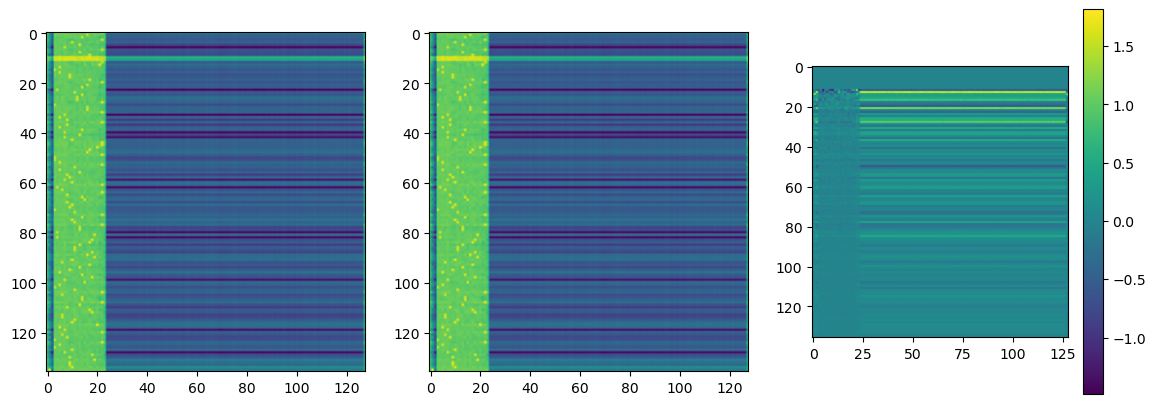

In [45]:
# Stack the tensors along a new dimension (axis=0)
stacked_scores = torch.stack([s for s in outputs.scores], dim=0)
print(stacked_scores.squeeze().shape)

## Check if the outputs of one-pass or autoregressive are identical
## Results: they are, the masked aminoacid is correct, but the next aminoacid is not
onepass_output = tokenizer.decode(torch.argmax(emb.logits.squeeze(), dim=1))
autoreg_output = tokenizer.decode(torch.argmax(stacked_scores.squeeze(), dim=1))

print(onepass_output)
print(autoreg_output)
print(masked_test)
print(input_test)
assert onepass_output == autoreg_output

fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.imshow(emb.logits.squeeze())
ax2.imshow(stacked_scores.squeeze())
im3 = ax3.imshow(emb.logits.squeeze() - stacked_scores.squeeze())
plt.colorbar(im3)
plt.show()

In [ ]:
# Repeat the experiment, but without masked AAs <masks>

with torch.no_grad():
    emb = fullmodel(input_ids=true_ids, labels=true_ids)

with torch.no_grad():
    outputs = fullmodel.generate(input_ids=true_ids, 
                                 max_length=200,
                                 labels=true_ids,
                                 return_dict_in_generate=True,
                                 output_scores=True)

stacked_scores = torch.stack([s for s in outputs.scores], dim=0)


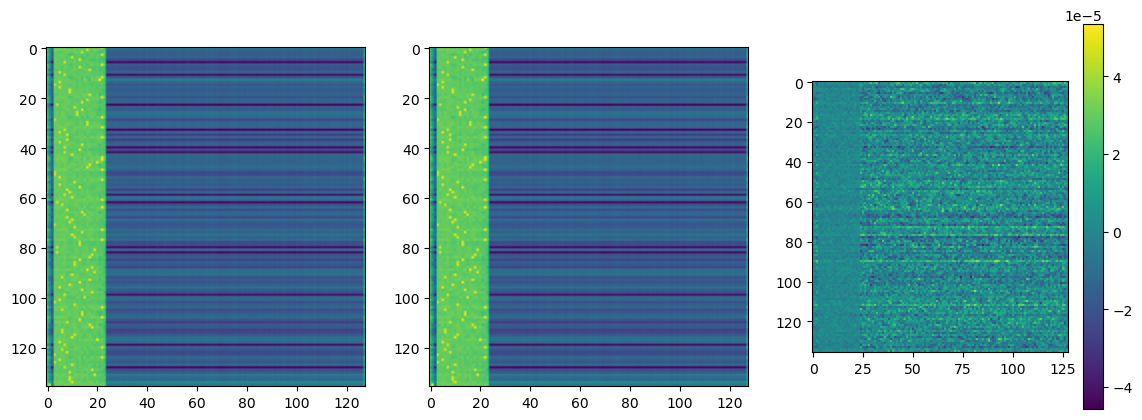

In [43]:

fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.imshow(emb.logits.squeeze())
ax2.imshow(stacked_scores.squeeze())
im3 = ax3.imshow(emb.logits.squeeze() - stacked_scores.squeeze())
plt.colorbar(im3)
plt.show()

In [ ]:
fullmodel.config

T5Config {
  "_name_or_path": "models/prottrans_t5_xl_u50/",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 16384,
  "d_kv": 128,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 32,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.31.0",
  "use_cache": true,
  "vocab_size": 128
}

In [ ]:
fullmodel

T5ForConditionalGeneration(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
              (dro